# Question tagging with BERT (HuggingFace)

In instances where an individual poses a health-related query/description, there may be underlying themes linked to the question that aren't immediately apparent. In this endeavor, we employ a BERT model to identify and tag medical issues related to patient inquiries. This is achieved by leveraging extensive datasets from ehealth, icliniq, QuestionDoctorsQA, and WebMDQA websites.

## Import libraries

For reproducible purpose, we set some seed for random. We also check if there is GPU that we can use for training to use. Otherwise, we use CPU for training.

In [1]:
import random
import numpy as np
import transformers
from datasets import load_dataset
from transformers import DistilBertTokenizerFast
from transformers import DistilBertConfig, TFDistilBertForQuestionAnswering
import tensorflow as tf
import time

def set_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
    try:
        transformers.trainer_utils.set_seed(seed)
    except NameError:
        print("Warning: transformers module is not imported. Setting the seed for transformers failed.")
        
# Fixing the random seed
random_seed=4321
set_random_seed(random_seed)

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("No GPU found!")
  pass

## Download the dataset

Datasets were downloaded from https://github.com/LasseRegin/medical-question-answer-data

## Load dataset from json file

In [2]:
import pandas as pd

I already downloaded and extract the datasests, so we only need to load it here. I use Pandas package to load JSON format

In [3]:
ehealth = pd.read_json('ehealthforumQAs.json')
icliniqQAs = pd.read_json('icliniqQAs.json')
questionDoctorQAs = pd.read_json('questionDoctorQAs.json')
webmdQAs = pd.read_json('webmdQAs.json')


We have a look at the structure of datasets. We have 3 important components: Question, Answer, and Tag. Tag is more about the category of the question. Note that Tags were not classify, so we cannot use it as it is.

In [115]:
webmdQAs.head(10)

,answer,question,url,tags
0,adhd and bipolar mood disorder (bmd) can coexi...,my 5 1/2-year-old son displays adhd symptoms f...,http://answers.webmd.com/answers/1194205/my-5-...,[attention deficit hyperactivity disorder]
1,stimulants in general tend to decrease appetit...,my son has add and mild autism. he has been su...,http://answers.webmd.com/answers/1194206/my-so...,"[autism, weight loss]"
2,while any of the stimulant medications can inc...,my son is 13 and is depressed. he has been tak...,http://answers.webmd.com/answers/1198557/my-so...,[]
3,seventy percent of teens diagnosed when they a...,my 17-year-old has stopped taking concerta aft...,http://answers.webmd.com/answers/1195455/my-17...,[attention deficit hyperactivity disorder]
4,try claritin-d which is located behind the pha...,i've been taking respa-ar for allergies. i can...,http://answers.webmd.com/answers/1182576/i-ve-...,[allergy]
5,i am very happy to answer this question. the p...,what is the role of a pharmacist in a communit...,http://answers.webmd.com/answers/1182574/what-...,[]
6,get an evaluation asap. you can start with you...,my daughter is 15 months old has had severe fe...,http://answers.webmd.com/answers/5084550/my-da...,"[feeding, birth, baby]"
7,your body responds to food intake with hunger ...,does your body know how many calories you eat ...,http://answers.webmd.com/answers/5083875/does-...,"[calorie, weight loss, food, pepper, snack]"
8,some medications are available in liquid formu...,i have trouble swallowing pills. can my prescr...,http://answers.webmd.com/answers/1182575/i-hav...,[swallow]
9,generally a diet free from alcohol and low in ...,i need a list of foods that i can eat and list...,http://answers.webmd.com/answers/5084356/i-nee...,"[food, pancreatitis]"


In [114]:
questionDoctorQAs.head(10)

,answer,answer_author,question,question_text,tags,url
0,you can stay assured you are fine free of hiv....,Dr. Ayman Darrag,is my anti hiv test conclusive or need retest?,Is my Anti Hiv Test Conclusive or need retest?,[hiv test],https://questiondoctors.com/is-my-anti-hiv-tes...
1,hi you are 100 % hiv free good luck,Dr Ahmed Fawzy,is my anti hiv test conclusive or need retest?,Is my Anti Hiv Test Conclusive or need retest?,[hiv test],https://questiondoctors.com/is-my-anti-hiv-tes...
2,your time slots of the tests and the final res...,Dr.Honey,is my anti hiv test conclusive or need retest?,Is my Anti Hiv Test Conclusive or need retest?,[hiv test],https://questiondoctors.com/is-my-anti-hiv-tes...
3,hi i see no labrum tear however i see acetabul...,Dr Ahmed Fawzy,i have some hip pain 9 weeks. had mra image re...,I have some hip pain 9 weeks. Had MRA image re...,[magnetic resonance angiography (mra)],https://questiondoctors.com/i-have-some-hip-pa...
4,no visible tear in labrum but obviously calcif...,Dr. Ayman Darrag,i have some hip pain 9 weeks. had mra image re...,I have some hip pain 9 weeks. Had MRA image re...,[magnetic resonance angiography (mra)],https://questiondoctors.com/i-have-some-hip-pa...
5,hi. it does not look like tear of labrum so i ...,Dr.Honey,i have some hip pain 9 weeks. had mra image re...,I have some hip pain 9 weeks. Had MRA image re...,[magnetic resonance angiography (mra)],https://questiondoctors.com/i-have-some-hip-pa...
6,in my opinion there is no labrum tear,Dr. D. Zluf,i have some hip pain 9 weeks. had mra image re...,I have some hip pain 9 weeks. Had MRA image re...,[magnetic resonance angiography (mra)],https://questiondoctors.com/i-have-some-hip-pa...
7,in my opinion if you have something other than...,Dr. Ayman Darrag,i developed breathing difficulties approx 2 ye...,I developed breathing difficulties approx 2 ye...,[hyperventilation],https://questiondoctors.com/i-developed-breath...
8,also have barely any air to exhale,trina,i developed breathing difficulties approx 2 ye...,I developed breathing difficulties approx 2 ye...,[hyperventilation],https://questiondoctors.com/i-developed-breath...
9,let me tell you that your main problem is anxi...,Dr Masr,i developed breathing difficulties approx 2 ye...,I developed breathing difficulties approx 2 ye...,[hyperventilation],https://questiondoctors.com/i-developed-breath...


In [113]:
ehealth.head(10)

,answer,question,url,tags
0,stopping smoking is about will power and being...,how do i stop smoking now,http://ehealthforum.com/health/stop-smoking-qu...,"[addiction, stop smoking]"
1,hello this sounds quite unfamiliar that due to...,i had a tubaligation 4 years ago and also have...,http://ehealthforum.com/health/endometriosis-q...,"[pregnancy, diet, endometriosis]"
2,extra caffeine can cause gastric discomfort th...,could extra caffeine consumption be a cause of...,http://ehealthforum.com/health/caffeine-consum...,"[breast cancer, cancer, breasts]"
3,hello thanks for submitting your question here...,"hello- i am a 24 year old female 5""4 & 115 lb ...",http://ehealthforum.com/health/pcos-one-ovary-...,"[hair loss, diet, acne, ovulation and ovaries]"
4,i am glad to help you out. this is not possibl...,i was wanting to know if you could tell me if ...,http://ehealthforum.com/health/not-knowing-you...,"[am i pregnant, pregnant, urine pregnancy test..."
5,you are not alone. you should consider expert ...,i have been taking methadose and oxycotin ille...,http://ehealthforum.com/health/topic51352.html,"[addiction, recovery]"
6,it is difficult to analyse your situation with...,i need help i drink every night and think that...,http://ehealthforum.com/health/i-need-help-i-d...,"[depression, addiction, recovery]"
7,given the description you could be experiencin...,i have had a lot of trouble getting off of nar...,http://ehealthforum.com/health/topic84923.html,"[withdrawal, narcotics, drug addiction treatme..."
8,it does not take much force at all to crush th...,hi. my name is roberto writing from italy. i w...,http://ehealthforum.com/health/clinical-trials...,"[clinical trials, research, and studies]"
9,medicines that contain iron like tonoferon usu...,the stool color is black (not loose) - is the ...,http://ehealthforum.com/health/topic124662.html,[general community chat]


In [112]:
icliniqQAs.head(10)

,answer,question,question_text,tags,url
0,from your description it appears that you may ...,is it fine to exercise with knee pain?,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 24 ye...",[exercises],https://www.icliniq.com/qa/knee-pain/is-it-fin...
1,depression anxiety restlessness and panic atta...,suffering from anxiety restlessness and taking...,"\r\n\r\n\r\n\t\t\t\t\tDear Doctor,\nI am suffe...",[anxiety],https://www.icliniq.com/qa/anxiety/suffering-f...
2,patients with hypothyroidism usually gain weig...,can a thyroid patient eat soybean and fenugreek?,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,I am a 23 year...",[hypothyroidism],https://www.icliniq.com/qa/thyroid-problem/can...
3,fenugreek seed cannot affect your fertility do...,i am not getting my periods after taking fenug...,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 23 ye...",[delayed period],https://www.icliniq.com/qa/missed-period/i-am-...
4,your problem is a characteristic of cholinergi...,kindly suggest me a therapy to overcome heat a...,"\r\n\r\n\r\n\t\t\t\t\tHello doctor,\nFrom one ...",[levocetirizine],https://www.icliniq.com/qa/cholinergic-urticar...
5,how are you doing? sorry to hear what you have...,can taking multiple antibiotics cause redness ...,"\r\n\r\n\r\n\t\t\t\t\tHello doctor,\nEver sinc...",[antibiotics],https://www.icliniq.com/qa/dryness-of-vagina/c...
6,thank you for the detailed information. i am h...,other than baclofen which medicine can be used...,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nMy dad is wi...",[physiotherapy],https://www.icliniq.com/qa/muscle-stiffness/ot...
7,i read through your query and understood your ...,my fiance is having diabetes type 2. will she ...,"\r\n\r\n\r\n\t\t\t\t\tHello,\nMy fiance is hav...",[diabetes],https://www.icliniq.com/qa/type-2-diabetes-mel...
8,in your paternal family is there any history o...,one of the hairs in eyebrow has changed to blo...,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 24 ye...",[vitiligo],https://www.icliniq.com/qa/vitiligo/one-of-the...
9,i can understand your concern regarding your s...,my son has severe constipation after taking pa...,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI have a twe...",[constipation],https://www.icliniq.com/qa/constipation/my-son...


Alright, we need to combine all the datasets to one for training and testing. Let's say it is all_QA data

In [8]:
con_QAs = [icliniqQAs.loc[:,["question", "answer", "tags"]],questionDoctorQAs.loc[:,["question", "answer", "tags"]],ehealth.loc[:,["question", "answer", "tags"]],webmdQAs.loc[:,["question", "answer", "tags"]]]

In [111]:
all_QA = pd.concat(con_QAs, ignore_index = True)
all_QA.head(10)

,question,answer,tags
0,is it fine to exercise with knee pain?,from your description it appears that you may ...,[exercises]
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety]
2,can a thyroid patient eat soybean and fenugreek?,patients with hypothyroidism usually gain weig...,[hypothyroidism]
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period]
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine]
5,can taking multiple antibiotics cause redness ...,how are you doing? sorry to hear what you have...,[antibiotics]
6,other than baclofen which medicine can be used...,thank you for the detailed information. i am h...,[physiotherapy]
7,my fiance is having diabetes type 2. will she ...,i read through your query and understood your ...,[diabetes]
8,one of the hairs in eyebrow has changed to blo...,in your paternal family is there any history o...,[vitiligo]
9,my son has severe constipation after taking pa...,i can understand your concern regarding your s...,[constipation]


In [110]:
all_QA['question'] = all_QA['question'].str.strip()
all_QA['answer'] = all_QA['answer'].str.strip()
all_QA['context'] = all_QA['question'] + " " + all_QA['answer']
all_QA.head(10)

,question,answer,tags,context,preprocessed_question,preprocessed_answer,question_len,answer_len,truncated_question,truncated_answer,tags_100
0,is it fine to exercise with knee pain?,from your description it appears that you may ...,[exercises],is it fine to exercise with knee pain? from yo...,is it fine to exercise with knee pain,from your description it appears that you may ...,8,90,is it fine to exercise with knee pain,from your description it appears that you may ...,[]
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety],suffering from anxiety restlessness and taking...,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,24,109,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety]
2,can a thyroid patient eat soybean and fenugreek?,patients with hypothyroidism usually gain weig...,[hypothyroidism],can a thyroid patient eat soybean and fenugree...,can a thyroid patient eat soybean and fenugreek,patients with hypothyroidism usually gain weig...,8,88,can a thyroid patient eat soybean and fenugreek,patients with hypothyroidism usually gain weig...,[]
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period],i am not getting my periods after taking fenug...,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,11,40,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[]
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine],kindly suggest me a therapy to overcome heat a...,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,9,118,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[]
5,can taking multiple antibiotics cause redness ...,how are you doing? sorry to hear what you have...,[antibiotics],can taking multiple antibiotics cause redness ...,can taking multiple antibiotics cause redness ...,how are you doing sorry to hear what you have ...,10,278,can taking multiple antibiotics cause redness ...,how are you doing sorry to hear what you have ...,[]
6,other than baclofen which medicine can be used...,thank you for the detailed information. i am h...,[physiotherapy],other than baclofen which medicine can be used...,other than baclofen which medicine can be used...,thank you for the detailed information i am ha...,11,210,other than baclofen which medicine can be used...,thank you for the detailed information i am ha...,[]
7,my fiance is having diabetes type 2. will she ...,i read through your query and understood your ...,[diabetes],my fiance is having diabetes type 2. will she ...,my fiance is having diabetes type 2 will she f...,i read through your query and understood your ...,14,182,my fiance is having diabetes type 2 will she f...,i read through your query and understood your ...,[]
8,one of the hairs in eyebrow has changed to blo...,in your paternal family is there any history o...,[vitiligo],one of the hairs in eyebrow has changed to blo...,one of the hairs in eyebrow has changed to blo...,in your paternal family is there any history o...,13,107,one of the hairs in eyebrow has changed to blo...,in your paternal family is there any history o...,[]
9,my son has severe constipation after taking pa...,i can understand your concern regarding your s...,[constipation],my son has severe constipation after taking pa...,my son has severe constipation after taking pa...,i can understand your concern regarding your s...,10,99,my son has severe constipation after taking pa...,i can understand your concern regarding your s...,[]


## There are some contraction format in the Q and A, we need to replace them to the normal form

In [11]:
import re
#preprocessing questions and answers.
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"<link>", "", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def preprocess(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    
    text = text.lower()
    text = text.strip()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub('>','',text)
    return text


all_QA['preprocessed_question'] = all_QA['question'].apply(preprocess)
all_QA['preprocessed_answer'] = all_QA['answer'].apply(preprocess)
all_QA.head()

,question,answer,tags,context,preprocessed_question,preprocessed_answer
0,is it fine to exercise with knee pain?,from your description it appears that you may ...,[exercises],is it fine to exercise with knee pain? from yo...,is it fine to exercise with knee pain,from your description it appears that you may ...
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety],suffering from anxiety restlessness and taking...,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...
2,can a thyroid patient eat soybean and fenugreek?,patients with hypothyroidism usually gain weig...,[hypothyroidism],can a thyroid patient eat soybean and fenugree...,can a thyroid patient eat soybean and fenugreek,patients with hypothyroidism usually gain weig...
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period],i am not getting my periods after taking fenug...,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine],kindly suggest me a therapy to overcome heat a...,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...


In [12]:
all_QA['preprocessed_question'] = all_QA['preprocessed_question'].str.strip()
all_QA['preprocessed_answer'] = all_QA['preprocessed_answer'].str.strip()
all_QA['context'] = all_QA['preprocessed_question'] + all_QA['preprocessed_answer']

## Find the length of questions and answers. It is needed for training to reduce the memory for unnecessary tasks. Why? Because we will use BERT model and transfer it to our data. BERT (we is going to use) can handle max length of sequence of 512. If our data has shorter, we use need to reduce the max length. If we have longer, we may need to find other models that can take care of it or we must truncated our data (questions and answers)

We are looking for some statistics to see the length of questions and answers. It will give us some clues what to choose for max length of sentences.

In [13]:


#finding the lens of preprocessed questions and answers
all_QA['question_len']=all_QA['preprocessed_question'].apply(lambda x: len(x.split(' ')))
all_QA['answer_len']=all_QA['preprocessed_answer'].apply(lambda x: len(x.split(' ')))
     


Length of sentences by percentile

In [14]:
all_QA['question_len'].quantile([.1,.25,.50,.75,.90,.99])

0.10      7.0
0.25     11.0
0.50     18.0
0.75     49.0
0.90     96.0
0.99    124.0
Name: question_len, dtype: float64

In [15]:
all_QA['question_len'].max()

425

In [16]:
all_QA['answer_len'].max()

1333

In [17]:
all_QA['answer_len'].quantile([.1,.25,.50,.75,.90,.99])

0.10     21.0
0.25     35.0
0.50     61.0
0.75    114.0
0.90    200.9
0.99    495.0
Name: answer_len, dtype: float64

Some answers are very long, however, they are mostly less than 125 and the question is no longer than 125. So, we will use max length for training as 125.

## We use max length of Q and A as 125.

Thus, we need to cut any answers that is longer than 125 to 125.

In [18]:
all_QA['truncated_question']=all_QA.apply(lambda x: ' '.join(x.preprocessed_question.split(' ')[:125]) if x.question_len>125 else x.preprocessed_question ,axis=1)
all_QA['truncated_answer']=all_QA.apply(lambda x: ' '.join(x.preprocessed_answer.split(' ')[:125]) if x.answer_len>495 else x.preprocessed_answer ,axis=1)


In [19]:
all_QA['truncated_answer'] = all_QA['truncated_answer'].str.strip()
all_QA['truncated_question'] = all_QA['truncated_question'].str.strip()

Let's call our truncated data now as dat_QA

In [109]:
dat_QA = all_QA.loc[:,['truncated_question','truncated_answer','tags']]
dat_QA.head(10)

,truncated_question,truncated_answer,tags
0,is it fine to exercise with knee pain,from your description it appears that you may ...,[exercises]
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety]
2,can a thyroid patient eat soybean and fenugreek,patients with hypothyroidism usually gain weig...,[hypothyroidism]
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period]
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine]
5,can taking multiple antibiotics cause redness ...,how are you doing sorry to hear what you have ...,[antibiotics]
6,other than baclofen which medicine can be used...,thank you for the detailed information i am ha...,[physiotherapy]
7,my fiance is having diabetes type 2 will she f...,i read through your query and understood your ...,[diabetes]
8,one of the hairs in eyebrow has changed to blo...,in your paternal family is there any history o...,[vitiligo]
9,my son has severe constipation after taking pa...,i can understand your concern regarding your s...,[constipation]


# We want to know how many different tags we have in the data

In [25]:
tags = []
for i in range(dat_QA.shape[0]):
    tags.extend(dat_QA.iloc[i,2])

In [26]:
import collections

In [108]:
tags[:20]

['exercises',
 'anxiety',
 'hypothyroidism',
 'delayed period',
 'levocetirizine',
 'antibiotics',
 'physiotherapy',
 'diabetes',
 'vitiligo',
 'constipation',
 'complete blood count',
 'genetic inheritance',
 'vitiligo',
 'thyroid problem',
 'thyroid problem',
 'vitiligo',
 'premature ejaculation',
 'constipation',
 'premature ejaculation',
 'thyroid problem']

In [107]:
counter = collections.Counter(tags)

In [105]:
most_tags = counter.most_common(50)
most_tags[:20]

[('pregnancy', 2930),
 ('period', 1384),
 ('pain', 1274),
 ('exercise', 890),
 ('sexual intercourse', 809),
 ('coldness', 670),
 ('skin', 646),
 ('vision', 638),
 ('drug', 571),
 ('fever', 502),
 ('baby', 496),
 ('stomach', 493),
 ('burn', 482),
 ('nausea', 436),
 ('penis', 419),
 ('vagina', 418),
 ('drinking', 415),
 ('surgery', 409),
 ('injection', 408),
 ('anxiety', 394)]

In [30]:
most_tags[0][0]

'pregnancy'

In [ ]:
most_tags_list = [tag[0] for tag in most_tags]


In [104]:
most_tags_list[:20]

['pregnancy',
 'period',
 'pain',
 'exercise',
 'sexual intercourse',
 'coldness',
 'skin',
 'vision',
 'drug',
 'fever',
 'baby',
 'stomach',
 'burn',
 'nausea',
 'penis',
 'vagina',
 'drinking',
 'surgery',
 'injection',
 'anxiety']

In [32]:
all_QA['tags_100']=all_QA.apply(lambda x: list(set.intersection(set(x.tags), set(most_tags_list))) ,axis=1)

# for i in range(all_QA.shape[0]):
#     all_QA['tags_100'][i] = list(set.intersection(set(all_QA['tags'][i]), set(most_tags_list)))

In [103]:
all_QA.iloc[100:120]

,question,answer,tags,context,preprocessed_question,preprocessed_answer,question_len,answer_len,truncated_question,truncated_answer,tags_100
100,how to get relief from dandruff?,the causes of dandruff are any of the followin...,[salicylic acid],how to get relief from dandruffthe causes of d...,how to get relief from dandruff,the causes of dandruff are any of the followin...,6,101,how to get relief from dandruff,the causes of dandruff are any of the followin...,[]
101,i have developed hair dye allergy. please help.,as per the details given it seems that you hav...,[allergy],i have developed hair dye allergy please helpa...,i have developed hair dye allergy please help,as per the details given it seems that you hav...,8,111,i have developed hair dye allergy please help,as per the details given it seems that you hav...,[]
102,while treating a patient for depression when c...,you seem to be dealing with a patient with tre...,[selective serotonin reuptake inhibitors],while treating a patient for depression when c...,while treating a patient for depression when c...,you seem to be dealing with a patient with tre...,12,143,while treating a patient for depression when c...,you seem to be dealing with a patient with tre...,[]
103,i have twin baby girls. one of them is not gai...,keep trying to give breast feeds as much as po...,[baby constipation],i have twin baby girls one of them is not gain...,i have twin baby girls one of them is not gain...,keep trying to give breast feeds as much as po...,14,210,i have twin baby girls one of them is not gain...,keep trying to give breast feeds as much as po...,[]
104,my 4 month baby has not passed stools. please ...,it is common to have decrease in stool frequen...,[baby constipation],my 4 month baby has not passed stools please h...,my 4 month baby has not passed stools please help,it is common to have decrease in stool frequen...,10,130,my 4 month baby has not passed stools please help,it is common to have decrease in stool frequen...,[]
105,how to remove pimples and the scars on my face?,pimple is somewhat hormonal and due to oily sk...,[acne scars],how to remove pimples and the scars on my face...,how to remove pimples and the scars on my face,pimple is somewhat hormonal and due to oily sk...,10,351,how to remove pimples and the scars on my face,pimple is somewhat hormonal and due to oily sk...,[]
106,i brush my teeth twice daily. even then my tee...,even after brushing twice daily if your teeth ...,[dental scaling],i brush my teeth twice daily even then my teet...,i brush my teeth twice daily even then my teet...,even after brushing twice daily if your teeth ...,15,63,i brush my teeth twice daily even then my teet...,even after brushing twice daily if your teeth ...,[]
107,how to confirm my pregnancy?,the history typically suggests an implantation...,[missed period],how to confirm my pregnancythe history typical...,how to confirm my pregnancy,the history typically suggests an implantation...,5,173,how to confirm my pregnancy,the history typically suggests an implantation...,[]
108,does lexapro take a long time to start working?,if lexapro (escitalopram) caused insomnia then...,[selective serotonin reuptake inhibitors],does lexapro take a long time to start working...,does lexapro take a long time to start working,if lexapro escitalopram caused insomnia then i...,9,70,does lexapro take a long time to start working,if lexapro escitalopram caused insomnia then i...,[]
109,my period has been late by 4 days. i am trying...,i understand your concern completely here with...,[missed period],my period has been late by 4 days i am trying ...,my period has been late by 4 days i am trying ...,i understand your concern completely here with...,15,172,my period has been late by 4 days i am trying ...,i understand your concern completely here with...,[]


In [35]:
all_QA_tags = all_QA.loc[all_QA["tags_100"].str.len() !=0].reset_index()
all_QA_tags = all_QA_tags.loc[all_QA_tags['truncated_answer'].str.len() !=0].reset_index()
# all_QA.loc[all_QA["tags_100"].str.len() == 3]

In [36]:
all_QA_tags = all_QA_tags[['truncated_question', 'truncated_answer', 'tags_100']]

In [100]:
all_QA_tags.head(10)

,truncated_question,truncated_answer,tags_100
0,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety]
1,i am having headache and my period is late cou...,it can be a hormonal headache but hormonal hea...,[headache]
2,how to prevent headache in myopia,myopia is the most common refractive error at ...,[headache]
3,i am experiencing headaches due to light sensi...,we are here to help you your symptoms are sugg...,[headache]
4,i get headaches when i go out in the sun pleas...,the symptoms you have mentioned here are indic...,[headache]
5,my headache persists even after pituitary tumo...,i read your query and understand your concerns...,[headache]
6,is headache a symptom of hiv,i can understand your anxiety which is quite o...,[headache]
7,can headache occur as a side effect of bp medi...,first tell me in detail about your headache to...,[headache]
8,my daughter has headache blurred vision numbne...,i am afraid to say that the clinical history o...,[headache]
9,can pregnancy occur outside uterus,whatever your doctor said is true but there is...,[pregnancy]


In [102]:
all_QA_tags['tags_100'].head(20)

0       [anxiety]
1      [headache]
2      [headache]
3      [headache]
4      [headache]
5      [headache]
6      [headache]
7      [headache]
8      [headache]
9     [pregnancy]
10    [pregnancy]
11    [pregnancy]
12    [pregnancy]
13    [pregnancy]
14    [pregnancy]
15    [pregnancy]
16    [pregnancy]
17         [acne]
18         [acne]
19         [acne]
Name: tags_100, dtype: object

## Split data for training and testing

In [39]:
#splitting the data into train and validation
from sklearn.model_selection import train_test_split
train, validation = train_test_split(all_QA_tags, test_size=0.2,random_state=42,shuffle=True)
train, test = train_test_split(train, test_size=0.2,random_state=42,shuffle=True)

In [40]:
train.shape

(8835, 3)

In [41]:
validation.shape

(2761, 3)

In [42]:
test.shape

(2209, 3)

## Print the first 5 samples in the training set

In [43]:
train["truncated_question"][:5]

757      the most effective skin care  i am for normal ...
1265     my husband has a swollen finger and now his kn...
7739     just diagnosed with hpv do my huband of 17 yrs...
8445     does a migraine always include pain or can you...
11635    was on birth control for 3 years then i stoppe...
Name: truncated_question, dtype: object

In [44]:
for q, a in zip(train["truncated_question"][:5], train["tags_100"][:5]):
    print(f"{q} -> {a}\n")

the most effective skin care  i am for normal skincare but do not take my word for it try some out yourself study customer opinions and make your brain up next the most effective businesses may have a no risk assure you can send total or applied containers back and obtain a complete refund if you are not 100 pleased skin care -> ['skin']

my husband has a swollen finger and now his knee and foot are swollen what kind of dr should he see -> ['vision', 'swelling', 'foot']

just diagnosed with hpv do my huband of 17 yrs and i need to always use condoms for life now -> ['condom']

does a migraine always include pain or can you just have light sensitivity -> ['pain']

was on birth control for 3 years then i stopped a week later i got my period for a day then it stoped could i be prego -> ['period', 'pregnancy', 'birth control']



## Question tags with Bert

Now we will start our way to train a question answering model. The pretrained model we'll be using is [Bert](https://arxiv.org/pdf/1810.04805.pdf).

### Defining the tokenizer

We also set the max length to 495 here

### Convert some text to tokens with the tokenizer: To see and understand how tokenize works

## Converting the inputs to tokens

In adition to converting inputs to tokens and adding special tokens, it will truncate and pad inputs to the maximum length of the sequences defined in the model config. For example, you can check model config with, `tokenizer.model_max_length`.

In [45]:

import tensorflow as tf
from transformers import BertTokenizer, TFBertForPreTraining, TFAutoModel, AutoTokenizer

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", model_max_length = 125)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", model_max_length = 125)
bert_model = TFAutoModel.from_pretrained("bert-base-uncased", max_length = 125)

# from transformers import AutoTokenizer, TFAutoModel
# tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/BioRedditBERT-uncased", model_max_length = 125)

# bert_model = TFAutoModel.from_pretrained("cambridgeltl/BioRedditBERT-uncased", max_length = 125)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Vocabulary to binary code for tags

Since tag variable has many tags, so we need to find a way to convert tags to numeric values. In this project, we use StringLookup function from keras layer. As a result, we have a vector of length of the number of tags in dataset. The value of 1 in the vector means that the tag variable has the tag at that position.

In [46]:
tags_100 = tf.ragged.constant(all_QA_tags["tags_100"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(tags_100)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'pregnancy', 'period', 'pain', 'exercise', 'sexual intercourse', 'coldness', 'skin', 'vision', 'drug', 'fever', 'baby', 'stomach', 'burn', 'nausea', 'penis', 'vagina', 'drinking', 'surgery', 'injection', 'anxiety', 'weight', 'diet', 'rash', 'food', 'antibiotic', 'condom', 'ears', 'flu', 'swelling', 'smoking', 'headache', 'hand', 'eyes', 'ejaculation', 'birth control', 'diarrhea', 'head', 'shingles', 'leg', 'cough', 'breast', 'arm', 'high blood pressure', 'virus', 'acne', 'insurance', 'pregnancy test', 'chest', 'foot', 'stress']


In [47]:
len(vocab)

51

In [48]:
sample_label = all_QA_tags["tags_100"].iloc[15]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")


Original label: ['pregnancy']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]


In [49]:
lookup(sample_label)

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

An example how bert model works

In [50]:

input_ids = tokenizer("does show up in hair sample", add_special_tokens=True, return_tensors="tf")
# Batch size 1

outputs = bert_model(input_ids)
prediction_logits, seq_relationship_logits = outputs[:2]

In [51]:
input_ids

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 2515, 2265, 2039, 1999, 2606, 7099,  102]])>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]])>}

In [52]:
input_ids['input_ids']

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 2515, 2265, 2039, 1999, 2606, 7099,  102]])>

In [53]:
bert_model(input_ids)

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-0.35877097, -0.2436432 ,  0.02884691, ..., -0.37103823,
          0.34817886,  0.08836893],
        [-0.04475386, -0.3682535 ,  0.3098363 , ..., -0.21683535,
          0.7589135 , -0.36365938],
        [-0.4964576 , -0.1499548 ,  0.6971106 , ..., -0.4307014 ,
          0.37299612, -0.8714325 ],
        ...,
        [ 1.3492085 , -0.29993764,  0.7885003 , ..., -0.62087995,
         -0.13188845, -0.78739303],
        [ 0.52342206, -0.8765727 , -0.07321079, ..., -0.25163823,
         -0.05105691, -0.53487813],
        [ 0.94795084,  0.13952154, -0.3133632 , ...,  0.2914263 ,
         -0.65409744, -0.48502716]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.8937712 , -0.29594472,  0.03675489,  0.67154986,  0.23174734,
        -0.22914687,  0.91933614,  0.25051808,  0.12964685, -0.9999636 ,
        -0.13179019,  0.3247

In [54]:
input_ids['input_ids']

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 2515, 2265, 2039, 1999, 2606, 7099,  102]])>

In [55]:
bert_model(input_ids['input_ids'])

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-0.35877097, -0.2436432 ,  0.02884691, ..., -0.37103823,
          0.34817886,  0.08836893],
        [-0.04475386, -0.3682535 ,  0.3098363 , ..., -0.21683535,
          0.7589135 , -0.36365938],
        [-0.4964576 , -0.1499548 ,  0.6971106 , ..., -0.4307014 ,
          0.37299612, -0.8714325 ],
        ...,
        [ 1.3492085 , -0.29993764,  0.7885003 , ..., -0.62087995,
         -0.13188845, -0.78739303],
        [ 0.52342206, -0.8765727 , -0.07321079, ..., -0.25163823,
         -0.05105691, -0.53487813],
        [ 0.94795084,  0.13952154, -0.3133632 , ...,  0.2914263 ,
         -0.65409744, -0.48502716]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.8937712 , -0.29594472,  0.03675489,  0.67154986,  0.23174734,
        -0.22914687,  0.91933614,  0.25051808,  0.12964685, -0.9999636 ,
        -0.13179019,  0.3247

In [56]:
tokenizer.model_max_length

125

In [57]:
outputs


TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-0.35877097, -0.2436432 ,  0.02884691, ..., -0.37103823,
          0.34817886,  0.08836893],
        [-0.04475386, -0.3682535 ,  0.3098363 , ..., -0.21683535,
          0.7589135 , -0.36365938],
        [-0.4964576 , -0.1499548 ,  0.6971106 , ..., -0.4307014 ,
          0.37299612, -0.8714325 ],
        ...,
        [ 1.3492085 , -0.29993764,  0.7885003 , ..., -0.62087995,
         -0.13188845, -0.78739303],
        [ 0.52342206, -0.8765727 , -0.07321079, ..., -0.25163823,
         -0.05105691, -0.53487813],
        [ 0.94795084,  0.13952154, -0.3133632 , ...,  0.2914263 ,
         -0.65409744, -0.48502716]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.8937712 , -0.29594472,  0.03675489,  0.67154986,  0.23174734,
        -0.22914687,  0.91933614,  0.25051808,  0.12964685, -0.9999636 ,
        -0.13179019,  0.3247

In [58]:
prediction_logits

<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-0.35877097, -0.2436432 ,  0.02884691, ..., -0.37103823,
          0.34817886,  0.08836893],
        [-0.04475386, -0.3682535 ,  0.3098363 , ..., -0.21683535,
          0.7589135 , -0.36365938],
        [-0.4964576 , -0.1499548 ,  0.6971106 , ..., -0.4307014 ,
          0.37299612, -0.8714325 ],
        ...,
        [ 1.3492085 , -0.29993764,  0.7885003 , ..., -0.62087995,
         -0.13188845, -0.78739303],
        [ 0.52342206, -0.8765727 , -0.07321079, ..., -0.25163823,
         -0.05105691, -0.53487813],
        [ 0.94795084,  0.13952154, -0.3133632 , ...,  0.2914263 ,
         -0.65409744, -0.48502716]]], dtype=float32)>

In [59]:
len(vocab)

51

In [60]:
input_ids

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 2515, 2265, 2039, 1999, 2606, 7099,  102]])>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]])>}

Build model

In [61]:

# #importing the pretrained biobert tokenizer and the biobert model
# from transformers import AutoTokenizer, TFAutoModel
# tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/BioRedditBERT-uncased")

# bert_model = TFAutoModel.from_pretrained("cambridgeltl/BioRedditBERT-uncased")

Build our model for multi-label classification. We will get the output from Bert for question. Then we apply 

In [62]:
class TagsWithBert(tf.keras.Model):
    def __init__(
            self,
            trainable=False,
            name=''):
        super(TagsWithBert, self).__init__(name=name)
        # self.Flat = tf.keras.layers.Flatten()
        # self.tokenizer = tokenizer
        self.Dense512 = tf.keras.layers.Dense(512,  activation="relu")
        self.Drop1 = tf.keras.layers.Dropout(0.3)
        self.Dense256 = tf.keras.layers.Dense(256,  activation="relu")
        self.Drop2 = tf.keras.layers.Dropout(0.2)
        self.Dense128 = tf.keras.layers.Dense(128,  activation="relu")
        self.Dense_mul_tags = tf.keras.layers.Dense(len(vocab), activation = "sigmoid")
        self.biobert_model=bert_model
        self.biobert_model.trainable=trainable
        # self.cos=tf.keras.layers.Dot(axes=1,normalize=True)

    def call(self, inputs):
        # inputs = self.tokenizer(batch_inputs['question'])
        # question_embeddings=bert_model(input_ids = inputs['question'])
        question_embeddings = self.biobert_model(input_ids=inputs['question']).pooler_output
        # print("Hello")
        output = self.Dense512(question_embeddings)
        output = self.Drop1(output)
        output = self.Dense256(output)
        output = self.Drop2(output)
        output = self.Dense128(output)
        # print("Pass Dene256")
        output = self.Dense_mul_tags(output)
        # print("pass last layer")
        # print(output.shape)
    #   q_ffnn=self.Dense512(question_embeddings)
    #   a_ffnn=self.Dense256(answer_embeddings)
    #   output=self.cos([q_ffnn,a_ffnn])
        return {"label":output}
        # return output

In [63]:
train_label = [lookup(x).numpy() for x in train['tags_100']]

In [64]:
train_label[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [65]:
train['truncated_question'].values[0]

'the most effective skin care  i am for normal skincare but do not take my word for it try some out yourself study customer opinions and make your brain up next the most effective businesses may have a no risk assure you can send total or applied containers back and obtain a complete refund if you are not 100 pleased skin care'

In [66]:
MAX_LENGTH = 125
# import tensorflow as tf


# Tokenize, filter and pad sentences
def tokenize_and_filter(questions):
  tokenized_questions = []
  
  for question in questions:
    # generating sequences
    tokenized_question =  tokenizer.encode(question, truncation=True)
    # print("test1")
    # tokenized_question = tokenized_question.reshape([1,-1])
    tokenized_questions.append(tokenized_question)
    # print("test2")
  # padding the sequences
  tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_questions, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_questions



In [67]:
tokenize_and_filter(train['truncated_question'].values).shape

(8835, 125)

In [68]:
#tokenizing and padding the train questions and answers
train_questions = tokenize_and_filter(train['truncated_question'].values)
# train_questions = [x.reshape([1,-1]) for x in train_questions]

In [69]:
val_questions = tokenize_and_filter(validation['truncated_question'].values)
# val_questions = [x.reshape([1,-1]) for x in val_questions]

In [70]:
train_questions.shape

(8835, 125)

In [71]:
train_questions.shape

(8835, 125)

In [72]:
# import tensorflow as tf
BATCH_SIZE = 6
BUFFER_SIZE = 2000
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': train_questions
    },
    {
        'label': train_label
    }

))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [73]:
val_label = [lookup(x).numpy() for x in validation['tags_100']]

In [74]:
val_label[0].shape

(51,)

In [75]:
BATCH_SIZE = 6
BUFFER_SIZE = 2000
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': val_questions
    },
    {
        'label': val_label
    }

))

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [76]:
val_questions.shape

(2761, 125)

In [77]:
test_questions = tokenize_and_filter(test['truncated_question'].values)
test_label = [lookup(x).numpy() for x in test['tags_100']]
BATCH_SIZE = 1
BUFFER_SIZE = 2000
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': test_questions
    },
    {
        'label': test_label
    }

))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [78]:
model = TagsWithBert(trainable=True)
model.compile(
    loss="binary_crossentropy", optimizer="sgd", metrics=[tf.keras.metrics.CategoricalAccuracy()], run_eagerly=True
)

In [79]:
t=val_dataset.take(1)

In [80]:
t.get_single_element()[0]['question']

<tf.Tensor: shape=(6, 125), dtype=int32, numpy=
array([[  101,  2064,  6634,  4491,  3426,  2534, 14194, 22045,  1045,
         2572,  1037,  2321,  2095,  2214,  2611,  1998,  1045,  2031,
         2467,  2018, 10089,  2021,  2196,  2151,  6634,  4491,  2197,
         2305,  2174,  1045,  2001,  3564,  2894,  1999,  2026,  3103,
         9954,  2043,  1037,  2312,  5192,  2790,  2000,  4088,  3652,
         2077,  2026,  2159,  2009,  2921,  3652,  1998,  1045,  2288,
         2061, 10215,  1045,  2031,  2196,  2042,  2008,  6015,  2077,
         2009,  2001,  2995,  3571,  1999,  1996,  6770,  1997,  2026,
         4308,  2026,  2303,  2001, 10226,  1998,  1045,  2071,  4510,
         2693,  2026,  2540,  2001,  3868,  1998,  1045,  2001, 18972,
         1045,  2776, 20869,  2870,  2011,  4823,  2320,  1045,  2001,
         5475,  1045,  2371,  2200,  2200,  5458,  2054,  2001,  2023,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [81]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 125,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [82]:
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=3)
history = model.fit(train_dataset, validation_data=val_dataset,epochs=30, callbacks=[callback])

Epoch 1/30
1472/1472 [==============================] - 531s 361ms/step - loss: 0.1769 - categorical_accuracy: 0.1454 - val_loss: 0.1394 - val_categorical_accuracy: 0.2105
Epoch 2/30
1472/1472 [==============================] - 532s 362ms/step - loss: 0.1454 - categorical_accuracy: 0.1898 - val_loss: 0.1383 - val_categorical_accuracy: 0.2105
Epoch 3/30
1472/1472 [==============================] - 521s 354ms/step - loss: 0.1434 - categorical_accuracy: 0.1970 - val_loss: 0.1372 - val_categorical_accuracy: 0.2105
Epoch 4/30
1472/1472 [==============================] - 528s 358ms/step - loss: 0.1415 - categorical_accuracy: 0.2037 - val_loss: 0.1354 - val_categorical_accuracy: 0.2105
Epoch 5/30
1472/1472 [==============================] - 544s 369ms/step - loss: 0.1374 - categorical_accuracy: 0.2249 - val_loss: 0.1272 - val_categorical_accuracy: 0.2754
Epoch 6/30
1472/1472 [==============================] - 519s 353ms/step - loss: 0.1291 - categorical_accuracy: 0.2904 - val_loss: 0.1203 - v

We should train more with higher epochs = 50 or more if needed since the loss is still decreasing and accuracy is increasing after just 30 epochs. I don't want to wait more time for this demo purpose model. However, you can see that the results are very good as below for the predicted tags.

In [83]:
model.evaluate(test_dataset)

2209/2209 [==============================] - 246s 111ms/step - loss: 0.0305 - categorical_accuracy: 0.7537


[0.030517101287841797, 0.7537347078323364]

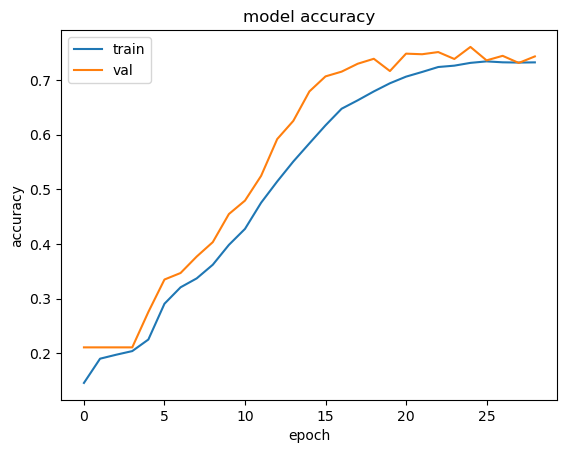

In [84]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

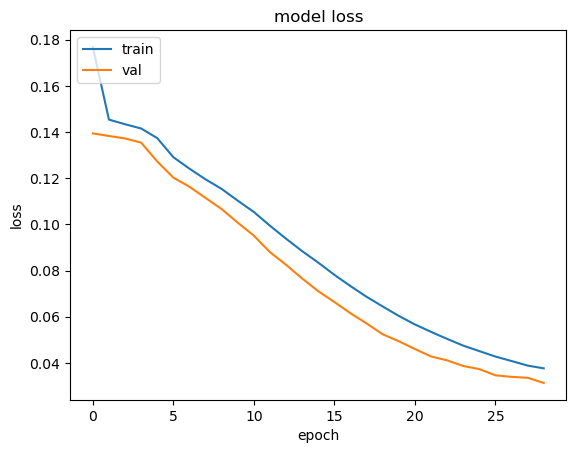

In [88]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [238]:
inference_dataset = test_dataset.take(100)

In [248]:
# Create a model for inference.

# Create a small dataset just for demoing inference.
# inference_dataset = val_dataset.take(100)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch['question']):
    label = label_batch['label'][i].numpy()
    print(f"Abstract: {tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(text))}")
    print(f"Label(s): {invert_multi_hot(label)}")
    predicted_proba = [proba for proba in predicted_probabilities['label']]
    # top_3_labels = [
    #     x
    #     for _, x in sorted(
    #         zip(predicted_probabilities['label'][i], lookup.get_vocabulary()),
    #         key=lambda pair: pair[0],
    #         reverse=True,
    #     )
    # ][:3]
    res = []
    for (x,y) in sorted(zip(predicted_probabilities['label'][i], lookup.get_vocabulary()), reverse=True):
        if (x >0.6):
            res.append((x,y))
        # print((x,y))

    # print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")

    print(f"Predicted probabilities (0.6 cut off):({res}")

    print(" ")


Abstract: [CLS] how effective is the tdap booster shot [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Label(s): ['injection']
Predicted probabilities (0.6 cut off):([(0.86384636, 'injection')]
 


In [96]:
# [(x,y) for (x,y) in (sorted(zip(predicted_probabilities['label'][i], lookup.get_vocabulary()), reverse=True) & (x >0.6))]
res = []
for (x,y) in sorted(zip(predicted_probabilities['label'][i], lookup.get_vocabulary()), reverse=True):
    if (x >0.6):
        res.append((x,y))
        # print((x,y))
print(res)

[(0.8370679, 'leg'), (0.7785309, 'pain')]


In [279]:
q = pd.DataFrame(data = {'q':["i remove mascara can not i just wash my makeup off with soap and water", 
"how effective is the tdap booster shot", "How can I reduce fever after getting vaccine shot?","How do I get my face clean after make up?"]})


In [280]:
q['q']

0    i remove mascara can not i just wash my makeup...
1               how effective is the tdap booster shot
2    How can I reduce fever after getting vaccine s...
3            How do I get my face clean after make up?
Name: q, dtype: object

In [281]:
test_check = tokenize_and_filter(q['q'].values)
# test_check_label = [lookup(x).numpy() for x in test['tags_100']]
BATCH_SIZE = 2
BUFFER_SIZE = 2000
test_check_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': test_check
    }
))

test_check_dataset = test_check_dataset.cache()
test_check_dataset = test_check_dataset.shuffle(BUFFER_SIZE)
test_check_dataset = test_check_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_check_dataset = test_check_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [286]:
# Create a model for inference.

# Create a small dataset just for demoing inference.
# inference_dataset = val_dataset.take(100)
text_batch = next(iter(test_check_dataset))
predicted_probabilities = model.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch['question']):
    # label = label_batch['label'][i].numpy()
    print(f"Abstract: {tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(text))}")
    # print(f"Label(s): {invert_multi_hot(label)}")
    predicted_proba = [proba for proba in predicted_probabilities['label']]
    # top_3_labels = [
    #     x
    #     for _, x in sorted(
    #         zip(predicted_probabilities['label'][i], lookup.get_vocabulary()),
    #         key=lambda pair: pair[0],
    #         reverse=True,
    #     )
    # ][:3]
    res = []
    for (x,y) in sorted(zip(predicted_probabilities['label'][i], lookup.get_vocabulary()), reverse=True):
        if (x > 0.2):
            res.append((x,y))
        # print((x,y))

    # print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")

    print(f"Predicted probabilities (0.6 cut off):({res}")

    print(" ")

Abstract: [CLS] how effective is the tdap booster shot [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Predicted probabilities (0.6 cut off):([(0.86384636, 'injection')]
 
Abstract: [CLS] how do i get my face clean after make up? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P